In [1]:
# Load data

import unidecode

headlines = list()
with open('data/headlines.txt') as f:
    for line in f:
        headline_norm = unidecode.unidecode(line[:-1].lower())  # remove accents with unidecode                                                            
        headlines.append(headline_norm)                         # and newline character

# Take a look at first 10 headlines
        
print(headlines[:10])

['zika outbreak hits miami', 'could zika reach new york city?', 'first case of zika in miami beach', 'mystery virus spreads in recife, brazil', 'dallas man comes down with case of zika', 'trinidad confirms first zika case', 'zika concerns are spreading in houston', 'geneve scientists battle to find cure', 'the cdc in atlanta is growing worried', 'zika infested monkeys in sao paulo']


In [2]:
# Create list of country and city names from geonamescache

import geonamescache

gc = geonamescache.GeonamesCache()

countries = []
countries_dic = gc.get_countries()

for key in countries_dic:
    countries.append(unidecode.unidecode(countries_dic[key]['name']))
    

countries.sort(key = len, reverse = True) # sort longest to shortest to avoid regex finding partial match

# Dictionary mapping unaccented country name to accented country name

country_accented_names = {unidecode.unidecode(country['name']): country['name'] 
                          for country in countries_dic.values() 
                          if country['name'] != unidecode.unidecode(country['name'])}

cities = []
cities_dic = gc.get_cities() 

for key in cities_dic:
    cities.append(unidecode.unidecode(cities_dic[key]['name']))
    
cities.sort(key = len, reverse = True) # sort longest to shortest to avoid regex finding partial match

# Dictionary mapping unaccented city name to accented city name

city_accented_names = {unidecode.unidecode(city['name']): city['name'] 
                       for city in cities_dic.values() 
                       if city['name'] != unidecode.unidecode(city['name'])}


# Take a look at first ten cities, countries, and accented names

print('Countries: ', countries[:10], '\n')
print('Cities: ', cities[:10], '\n')
print('Accented City Names: ', list(city_accented_names.values())[:10], '\n')
print('Accented Country Names: ', list(country_accented_names.values())[:10], '\n')


Countries:  ['South Georgia and the South Sandwich Islands', 'United States Minor Outlying Islands', 'Bonaire, Saint Eustatius and Saba ', 'Heard Island and McDonald Islands', 'Democratic Republic of the Congo', 'Saint Vincent and the Grenadines', 'British Indian Ocean Territory', 'French Southern Territories', 'Saint Pierre and Miquelon', 'Central African Republic'] 

Cities:  ['Chak Two Hundred Forty-nine Thal Development Authority', 'Dolores Hidalgo Cuna de la Independencia Nacional', 'Ampliacion San Mateo (Colonia Solidaridad)', 'Licenciado Benito Juarez (Campo Gobierno)', 'Sant Pere, Santa Caterina i La Ribera', 'Palikir - National Government Center', 'Nanchital de Lazaro Cardenas del Rio', 'San Fernando del Valle de Catamarca', "el Camp d'en Grassot i Gracia Nova", 'San Martin Texmelucan de Labastida'] 

Accented City Names:  ['Khawr Fakkān', 'Shīnḏanḏ', 'Shibirghān', 'Sang-e Chārak', 'Aībak', 'Rustāq', 'Qarqīn', 'Qarāwul', 'Pul-e Khumrī', 'Paghmān'] 

Accented Country Names:  []

In [3]:
# Check headlines for city and country

import re
import pandas as pd

# Create regex for countries 
country_reg_ex = ''
for place in countries:
    country_reg_ex += r'\b' + re.escape(place) +r'\b|' #\b to match entire place name
    
country_reg_ex = country_reg_ex[:-1]

# Look at first 100 characters in country_reg_ex

print('Country regex: ', country_reg_ex[:100])

country_reg_ex = re.compile(country_reg_ex, re.I)

# Create regex for countries 
city_reg_ex = r''
for place in cities:
    city_reg_ex +=r'\b' + re.escape(place) + r'\b|' #\b to match entire place name
    
city_reg_ex = city_reg_ex[:-1]+r'\b'

# Look at first 100 characters in city_reg_ex
print('City regex: ', city_reg_ex[:100])

city_reg_ex = re.compile(city_reg_ex,re.I)

headline_place_data = [['headline','city', 'country']]

for headline in headlines:
    countries_match = country_reg_ex.findall(headline)
    cities_match = city_reg_ex.findall(headline)
    if countries_match == []:
        country = ''
    else:
        countries_match.sort(key = len, reverse = True)
        country = countries_match[0].title()
        
    if cities_match == []:
        city = ''
    else:
        cities_match.sort(key = len, reverse = True)
        city = cities_match[0].title()
    headline_place_data.extend([[headline, city, country]])

headline_df = pd.DataFrame(headline_place_data[1:], columns=headline_place_data[0])

Country regex:  \bSouth\ Georgia\ and\ the\ South\ Sandwich\ Islands\b|\bUnited\ States\ Minor\ Outlying\ Islands\b|
City regex:  \bChak\ Two\ Hundred\ Forty\-nine\ Thal\ Development\ Authority\b|\bDolores\ Hidalgo\ Cuna\ de\ la\ 


In [4]:
# Check for common city names
headline_df.groupby('city').count().sort_values('headline', ascending=False).head(5) 
# shows cities incorrectly detected as 'hit', 'of' and 'come'

,headline,country
city,,
,31,31
Of,6,6
Monroe,4,4
Miami,4,4
Madrid,4,4


In [5]:
# Remove cities detected as 'hit', 'of' and 'come'
mask =(headline_df['city'] == 'Hit') | (headline_df['city'] =='Of' )|  (headline_df['city'] =='Come')

headline_df.loc[mask, 'city'] = ''

In [6]:
def find_largest_city_pop(city_dict):
    '''Returns geonameid of city in city_dict with largest population
    city_dict: subset of GeoNamesCache.get_cities()'''
    max_pop = -1
    if city_dict == []:
        return ''
    for city in city_dict:
        for key in city:
            if city[key]['population'] > max_pop:
                largest = city[key]['geonameid']
    return str(largest)

def restore_accent(city):
    if city in city_accented_names.keys():
        return city_accented_names[city]
    return city

def get_lon(geonameid):
    '''Returns longitude of city in gc.get_cities with geonameid = geonameid'''
    if geonameid == '':
        return ''                            
    return gc.get_cities()[geonameid]['longitude']

def get_lat(geonameid):
    '''Returns latitude of city in gc.get_cities with geonameid = geonameid'''
    if geonameid == '':
        return ''                            
    return gc.get_cities()[geonameid]['latitude']

def get_countrycode(geonameid):
    '''Returns countrycode in gc.get_cities with geonameid = geonameid'''
    if geonameid == '':
        return ''                            
    return gc.get_cities()[geonameid]['countrycode']

# Create long, lat, country code columns given city

mask = headline_df['city'].map(gc.get_cities_by_name).str.len() == 0
headline_df.loc[mask, 'city'] = headline_df.loc[mask, 'city'].map(restore_accent)

headline_df['longitude'] = headline_df['city'].map(gc.get_cities_by_name).map(find_largest_city_pop).map(get_lon)
headline_df['latitude'] = headline_df['city'].map(gc.get_cities_by_name).map(find_largest_city_pop).map(get_lat)
headline_df['country code'] = headline_df['city'].map(gc.get_cities_by_name).map(find_largest_city_pop).map(get_countrycode)

headline_df = headline_df[headline_df['longitude']!='']

In [7]:
# Check basic counts
headline_df.describe()

,headline,city,country,longitude,latitude,country code
count,607,607,607,607.00000,607.00000,607
unique,605,572,11,572.00000,572.00000,88
top,spanish flu spreading through madrid,Miami,,-3.70256,25.77427,US
freq,2,4,592,4.00000,4.00000,346


In [8]:
# Remove Duplicate headlines:
dup_rows = [headline_df[headline_df['headline'] == 'spanish flu spreading through madrid'].index[0],
            headline_df[headline_df['headline'] == 'spanish flu outbreak in lisbon'].index[0]]
headline_df = headline_df.drop(dup_rows)

In [354]:
# Cluster headlines using KMeans

from sklearn.cluster import KMeans
import numpy as np

def cluster_model(data, model, name = ''):
    features = data[['longitude', 'latitude']]
    cluster_column = 'clusters'
    data[cluster_column] = model.fit_predict(features)
    return data, len(set(data[cluster_column]))

In [355]:
import cartopy
from cartopy.crs import PlateCarree, LambertConformal


def map_cluster_plot(data, clusters, name = ''):
    
    labels = set(clusters)
    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(clusters)) - (1 if -1 in labels else 0)
    fig = plt.figure(figsize=(12, 8))
    if name == 'DBSCAN_in_US':
        ax = plt.axes(projection=LambertConformal())
        us_extent = (-120, -75, 20, 50)
        ax.set_extent(us_extent)
        ax.add_feature(cartopy.feature.STATES)
    else:
        ax = plt.axes(projection=PlateCarree())
        ax.set_global()
        
    for index in range(n_clusters):
        selected_headlines = [data.loc[i] for i in data.index[:-1] 
                              if index == clusters.loc[i]]
        x_coordinates, y_coordinates = np.array(selected_headlines).T
        ax.scatter(x_coordinates, y_coordinates,transform = PlateCarree(), s = 5)
    
    unclustered_cities = [data.loc[i] for i in data.index[:-1] 
                      if -1 == clusters.loc[i]]
    if np.array(unclustered_cities).T.size>0:
        x_coordinates, y_coordinates = np.array(unclustered_cities).T
        ax.scatter(x_coordinates, y_coordinates, s = 5, marker = '*', color = 'k')

    ax.coastlines()
    # ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND)
    if len(name)>0:
        ax.set_title("Distribution of Disease {} Clusters by {}".format(n_clusters,name),
                 fontsize=15, verticalalignment='bottom')
    else:
        ax.set_title("Distribution of Disease {} Clusters".format(n_clusters,name),
                 fontsize=15, verticalalignment='bottom')
    plt.show()
    return fig,ax

In [11]:
# Cluster with DBSCAN

from sklearn.cluster import DBSCAN
from math import cos, sin, asin

def travel_distance(coord1, coord2, radius=3956):
    """
    Calculates the great circle distance between two coordinates or arrays of coordinates.
    """
    if np.array_equal(coord1, coord2):
        return 0.0

    # Convert lat/lon to radians
    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    # Find the difference between the coordinates
    delta_x, delta_y = coord2 - coord1
    
    # Apply Haversin formula
    haversin = np.sin(delta_x / 2) ** 2 + np.product(
        [np.cos(coord1[0]), np.cos(coord2[0]), np.sin(delta_y / 2) ** 2]
    )

    # Convert to distance in miles
    return 2 * radius * np.arcsin(haversin ** 0.5)

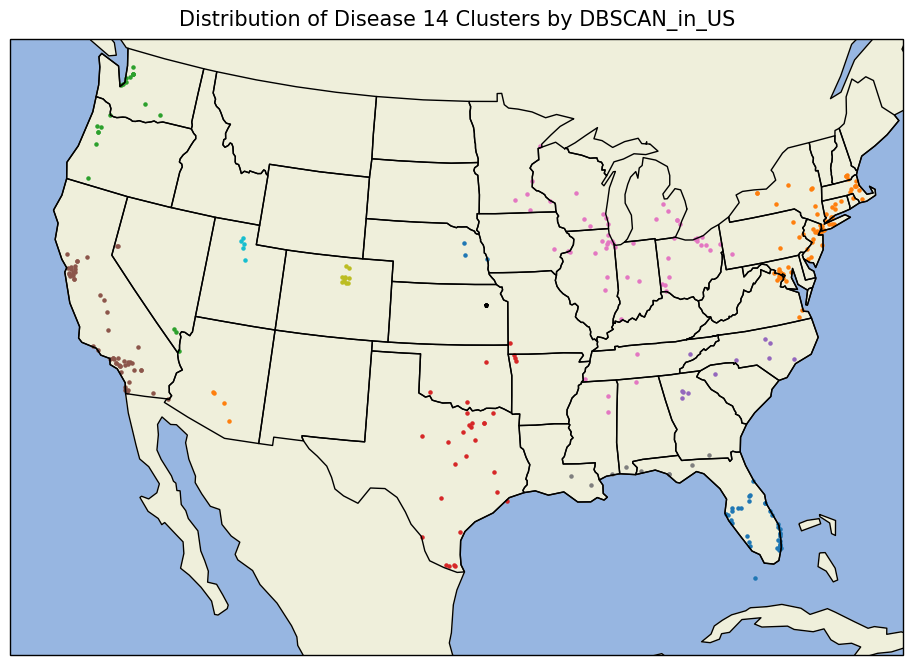

There are 15 clusters in DBSCAN_in_US
There are 27 unclustered cities in DBSCAN_in_US.


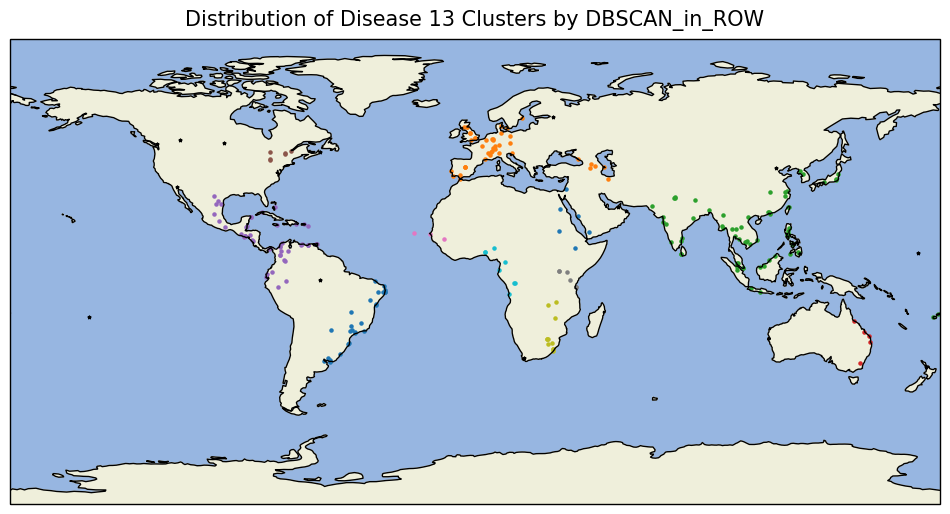

There are 14 clusters in DBSCAN_in_ROW
There are 15 unclustered cities in DBSCAN_in_ROW.


In [357]:
import matplotlib.pyplot as plt

# Cluster on US and ROW separately with DBSCAN-Euclidean

DB_euclidean = DBSCAN(metric = 'euclidean')
headline_df_US = headline_df[headline_df['country code'] == 'US'].copy()
headline_df_ROW = headline_df[headline_df['country code'] != 'US'].copy()

params_US = {'eps':2, 'min_samples':3}
params_ROW = {'eps':9, 'min_samples':3}

for data, params, name in [(headline_df_US, params_US, 'DBSCAN_in_US'),
                           (headline_df_ROW, params_ROW, 'DBSCAN_in_ROW')]:
    clusterer = DB_euclidean
    clusterer.eps = params['eps']
    clusterer.min_samples = params['min_samples']
    _,n_clusters = cluster_model(data, clusterer, name = name)
    fig, ax = map_cluster_plot(data[['longitude','latitude']],data['clusters'], name = name)
    unclustered_cities = [data.loc[i] for i in data.index[:-1] 
                      if -1 == data['clusters'].loc[i]]
    print('There are {} clusters in {}'.format(n_clusters, name))
    print('There are {} unclustered cities in {}.'.format(len(unclustered_cities), name))


In [360]:
for data, name in [(headline_df_US, 'DBSCAN_in_US'),
                           (headline_df_ROW, 'DBSCAN_in_ROW')]:
    labels = set(data['clusters'])
    clust_city_count = [(cluster, data[data['clusters'] == cluster]['city'].count()) 
                        for cluster in labels]
    clust_city_count.sort(key = lambda x: x[1], reverse = True)
    print('Ordered clusters for {}: '.format(name), clust_city_count, '\n')

Ordered clusters for DBSCAN_in_US:  [(1, 73), (6, 56), (5, 55), (0, 39), (-1, 27), (3, 26), (2, 19), (4, 11), (8, 11), (7, 9), (9, 5), (13, 5), (11, 4), (10, 3), (12, 3)] 

Ordered clusters for DBSCAN_in_ROW:  [(2, 76), (4, 50), (1, 37), (0, 27), (-1, 15), (8, 11), (9, 8), (5, 6), (7, 6), (10, 6), (11, 6), (3, 5), (6, 3), (12, 3)] 



In [388]:
def find_centre(cluster):
    '''Find coordinates of cluster centre'''
    cen_lon, cen_lat = cluster[['longitude','latitude']].mean()
    return cen_lon, cen_lat

# Dictionary listing cluster to centre in lon, lat

for data, name in [(headline_df_US, 'DBSCAN_in_US'),
                           (headline_df_ROW, 'DBSCAN_in_ROW')]:
    labels = set(data['clusters'])
    clust_centre = {cluster: find_centre(data[data['clusters'] == cluster][['longitude', 'latitude']])
                    for cluster in labels}

    # Calculate distance from centre
    f = lambda x: travel_distance(list(x[['longitude', 'latitude']]),
                                  clust_centre[x['clusters']])
    
    data['dist_to_centre'] = data[['longitude',
                                   'latitude',
                                   'clusters']].apply(f, axis='columns')
    
    pd.set_option('display.max_rows', 999)
    
    cities_by_centre = data.sort_values(by = ['clusters', 'dist_to_centre'])
    cities_by_centre = cities_by_centre[data['clusters']!=-1]
    
    #Look for headlines closest to centre
    if name == 'DBSCAN_in_US':
        n=10
    else: 
        n = 20
    print(name)
    print('*'*100)
    for cluster in labels:
        print('Most central {} cities in cluster {}'.format(n, cluster))
        print(data[data['clusters'] == cluster].headline[0:n], '\n')

/Users/nicholasbedard/anaconda3/envs/discovering-disease-outbreaks/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


DBSCAN_in_US
****************************************************************************************************
Most central 10 cities in cluster 0
0                        zika outbreak hits miami
2               first case of zika in miami beach
18           orlando volunteers aid zika research
21          tampa bay area zika case count climbs
52              zika symtomps spotted in key west
61     new zika case confirmed in sarasota county
95      case of hepatitis e reported in melbourne
98              zika patient in seminole, florida
101          can zika make it here to vero beach?
108                     doral hit by deadly virus
Name: headline, dtype: object 

Most central 10 cities in cluster 1
1                                              could zika reach new york city?
10                                       brownsville teen contracts zika virus
23                                              baltimore plans for zika virus
26                                         ph

DBSCAN_in_ROW
****************************************************************************************************
Most central 20 cities in cluster 0
3                                    mystery virus spreads in recife, brazil
5                                          trinidad confirms first zika case
9                                         zika infested monkeys in sao paulo
32                                                zika spreading to salvador
44                                       zika outbreak in piracicaba, brazil
64                                          second zika paitient in brasilia
78                                          student sick in campinas, brazil
94                                 new zika case confirmed in belo horizonte
106    authorities are worried about the spread of norovirus in buenos aires
145                               zika alert for rio grande valley residents
165                       montevideo encounters severe symptoms of rotavirus
16

In [411]:
# Cluster to diseases by proximity to centre (top 10)
    # Exluded west nile and mad cow, and doesn't distinguish hep types
disease_by_cluster_prox_ROW = {
    0:['Zika', 'Norovirus', 'Rotavirus'],
    1:['Bronchitis', 'Meningitis', 'Varicella', 'Chlamydia'],
    2:['Zika', 'Malaria'],
    3:['Zika','Meningitis', 'Bronchitis', 'Norovirus'],
    4:['Zika','Meningitis'],
    5:['Hepatitis', 'Malaria'],
    6:['Cholera', 'Pneumonia','Hepatitis'],
    7:['Ebola', 'Cholera','Malaria'],
    8:['Malaria','Pneumonia','Chickenpox',
       'Tuberculosis',' Chikungunya'],
    9:['Tuberculosis', 'Hepatitis','Mumps','Malaria'
       'Vericella','Pneumonia'],
    10:['Chikungunya','Chlamydia','Hepatitis'],
    11:['Bronchitis','Hepatitis','Herpes'],
    12:['HIV','Rotavirus'],
    -1:['']
}

disease_by_cluster_prox_US = {
    0:['Zika'],
    1:['Zika','Flu','Bronchitis','Dengue',
       'HIV'],
    2:['Zika', 'Measles', 'Pneumonia', 'syncytial'
       'Hepatitis'],
    3:['Zika','Flu', 'Rotavirus'],
    4:['Zika','Norovirus','Chlamydia',
       'Rhinovirus','Dengue','HIV'],
    5:['Zika', 'Hepatitis', 
       'Rhinovirus'],
    6:['Zika', 'Rabies'],
    7:['Zika', 'Chlamydia'],
    8:['Gonorrhea','Zika','Chikungunya',
       'HIV',' Hepatitis','Syphilis'],
    9:['Dengue', 'Chlamydia','Gonorhea',
       'Pneumonia'],
    10:['Zika','Rotovirus'],
    11:['Hepatitis','Pneumonia','chikungunya'],
    12:['Pneumonia','syncytial'],
    13:['Measles','Hepatitis','Mumps','Zika'],
    -1:['']
}

In [412]:
#Look for most frequent words
for data, name in [(headline_df_US, 'DBSCAN_in_US'),
                           (headline_df_ROW, 'DBSCAN_in_ROW')]:
    labels = set(data['clusters'])
    n=1
    print(name)
    print('*'*100)
    for cluster in labels:
        print('Word frequency in cluster {} -- above {}'.format(cluster, n))
        word_count = pd.Series(' '.join(data[data['clusters'] == cluster].headline).split()).value_counts()
        print(word_count[word_count>n],'\n')

DBSCAN_in_US
****************************************************************************************************
Word frequency in cluster 0 -- above 1
zika         35
in           21
beach         8
reported      8
to            7
miami         7
case          6
spreads       5
outbreak      4
of            3
patients      3
spotted       3
more          3
arrives       3
fort          3
by            2
north         2
symptoms      2
troubles      2
hits          2
virus         2
melbourne     2
palm          2
a             2
west          2
dtype: int64 

Word frequency in cluster 1 -- above 1
in              43
of              17
hepatitis       10
the             10
spread          10
vaccine          9
are              9
authorities      8
outbreak         8
with             7
virus            7
spreading        6
about            6
to               6
more             6
dengue           6
symptoms         6
new              5
re-emerges       5
zika             5
cow          

In [413]:
# Cluster to diseases by frequency in headlines

disease_by_cluster_freq_ROW = {
    0:['Zika'],
    1:['Rabies','Meningitis','Hepatitis', 
       'Norovirus','Tuberculosis'],
    2:['Zika', 'Hepatitis','Tuberculosis','Norovirus'],
    3:['Zika'],
    4:['Zika','Flu','Influenza','Meningitis'],
    5:['Hepatitis'],
    6:[''],
    7:['Malaria'],
    8:['Pneumonia'],
    9:['Malaria','Tuberculosis'],
    10:['Rabies'],
    11:[''],
    12:['Rotavirus'],
    -1:['']
}

disease_by_cluster_freq_US = {
    0:['Zika'],
    1:['Hepatitis','Dengue','Zika', 'Mumps','Measles',
       'Tuberculosis', 'Rotavirus', 'Chlamydia', 
       'Syphilis','Influenza','Chickenpox','HIV',
       'Varicella','chikungunya','Rhinovirus','Herpes','Malaria','Syncytial'],
    2:['Hepatitis', 'Zika','syncytial'],
    3:['Zika'],
    4:['Zika'],
    5:['Zika', 'Hepatitis', 'Tuberculosis', 
       'Rhinovirus', 'Chickenpox', 'Flu','Bronchitis',
       'Herpes','Mumps', 'Norwalk', 'Gonorrhea', 
       'Pneumonia'],
    6:['Zika', 'Hepatitis','Rhinovirus','Norovirus',
       'Chickenpox','Rotavirus', 'Herpes','Varicella',
       'Dengue', 'Meningitis', 'Malaria','Measles', 
       'Gonorrhea', 'Mumps'],
    7:['Zika'],
    8:['Zika'],
    9:[''],
    10:[''],
    11:[''],
    12:[''],
    13:[''],
    -1:['']
}

In [414]:
# Cluster to disease in cluster by proximity to centre if appearing at least twice
repeated_disease_byCluster = {}
for dict_prox, dict_freq, name in [[disease_by_cluster_prox_US, 
                                    disease_by_cluster_freq_US, 'US'],
                                   [disease_by_cluster_prox_ROW, 
                                    disease_by_cluster_freq_ROW, 'ROW']]:
    
    
    labels = set(dict_prox.keys())
    repeated_disease_byCluster[name] = {
        cluster: [disease for disease in dict_prox[cluster] 
                  if disease in dict_freq[cluster]] 
        for cluster in labels}
                                   
print('US: ', repeated_disease_byCluster['US'],'\n')
print('ROW: ', repeated_disease_byCluster['ROW'],'\n')

US:  {0: ['Zika'], 1: ['Zika', 'Dengue', 'HIV'], 2: ['Zika'], 3: ['Zika'], 4: ['Zika'], 5: ['Zika', 'Hepatitis', 'Rhinovirus'], 6: ['Zika'], 7: ['Zika'], 8: ['Zika'], 9: [], 10: [], 11: [], 12: [], 13: [], -1: ['']} 

ROW:  {0: ['Zika'], 1: ['Meningitis'], 2: ['Zika'], 3: ['Zika'], 4: ['Zika', 'Meningitis'], 5: ['Hepatitis'], 6: [], 7: ['Malaria'], 8: ['Pneumonia'], 9: ['Tuberculosis'], 10: [], 11: [], 12: ['Rotavirus'], -1: ['']} 



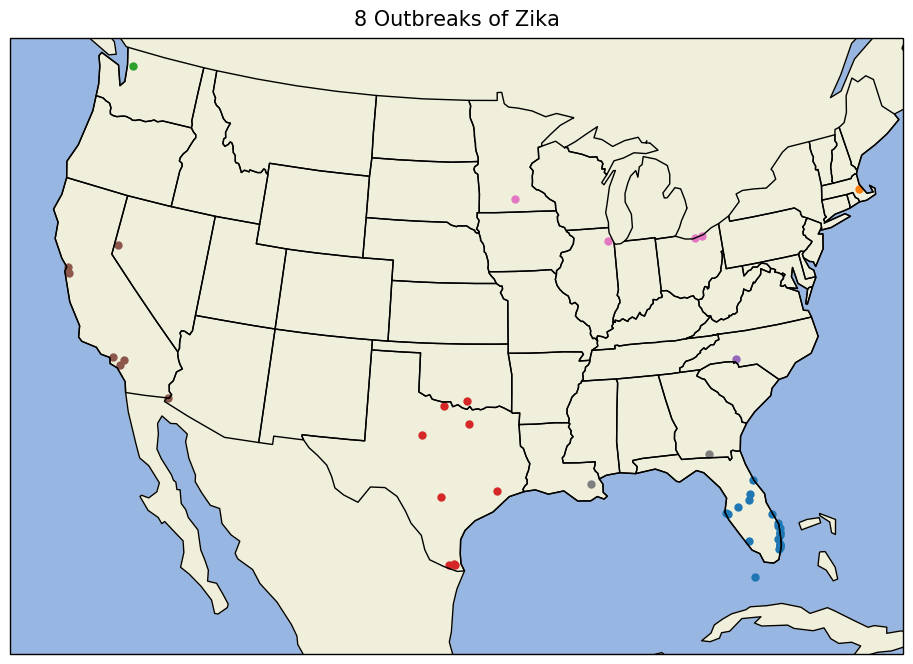

In [427]:
# American Map of Disease
data = headline_df_US
name = 'US'
data = data[data['clusters']>-1]
mask = [len(repeated_disease_byCluster[name][data['clusters'].loc[i]]) > 0 for i in data.index]
data = data[mask]
mask1 = [bool(re.match(repeated_disease_byCluster['US'][data['clusters'].loc[i]][0].lower(),
                       data['headline'].loc[i]
                      )
             ) for i in data.index]
data = data[mask1]

labels = set(data['clusters'])

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=LambertConformal())
us_extent = (-120, -75, 20, 50)
ax.set_extent(us_extent)
ax.add_feature(cartopy.feature.STATES)

n_clusters = 0
for cluster in labels:
    if len(repeated_disease_byCluster['US'][cluster]) == 0:
        continue
    main_outbreak = repeated_disease_byCluster['US'][cluster][0]
    n_clusters+=1
    selected_headlines = data[data['clusters'] == cluster][['longitude', 'latitude']]
    cn_lon, cn_lat = find_centre(selected_headlines)
    x_coordinates, y_coordinates = np.array(selected_headlines).T
    ax.scatter(x_coordinates, y_coordinates,transform = PlateCarree(), s = 25)
    #ax.text(cn_lon + 1, cn_lat, main_outbreak , fontsize=15, transform=PlateCarree())

ax.coastlines()
# ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)
ax.set_title("{} Outbreaks of Zika".format(n_clusters,name),
             fontsize=15, verticalalignment='bottom')
plt.show()

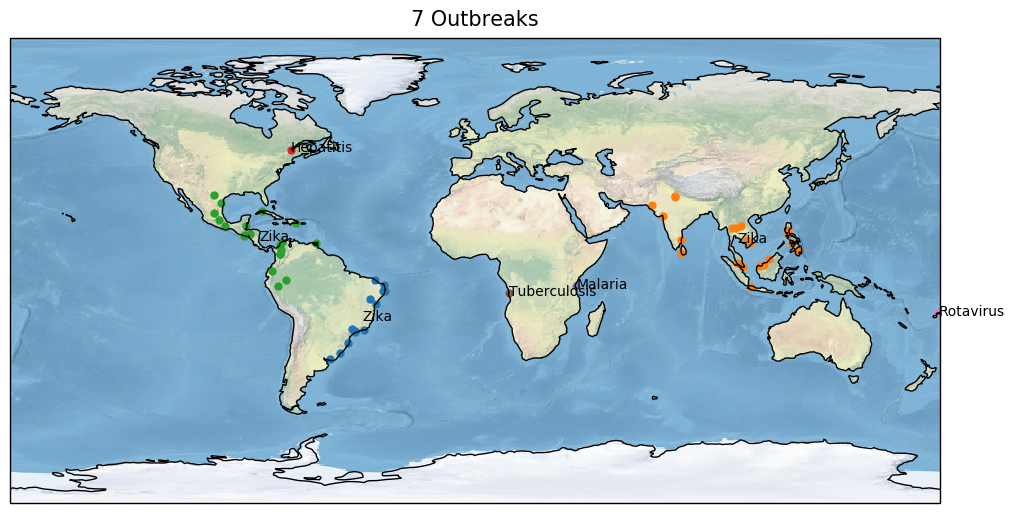

In [432]:
# ROW Map of Disease
data = headline_df_ROW
name = 'ROW'
data = data[data['clusters']>-1]
mask = [len(repeated_disease_byCluster[name][data['clusters'].loc[i]]) > 0 for i in data.index]
data = data[mask]
mask1 = [bool(re.match(repeated_disease_byCluster[name][data['clusters'].loc[i]][0].lower(),
                       data['headline'].loc[i]
                      )
             ) for i in data.index]
data = data[mask1]

labels = set(data['clusters'])

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=PlateCarree())
ax.stock_img()
ax.set_global()

n_clusters = 0
for cluster in labels:
    if len(repeated_disease_byCluster[name][cluster]) == 0:
        continue
    main_outbreak = repeated_disease_byCluster[name][cluster][0]
    n_clusters+=1
    selected_headlines = data[data['clusters'] == cluster][['longitude', 'latitude']]
    cn_lon, cn_lat = find_centre(selected_headlines)
    x_coordinates, y_coordinates = np.array(selected_headlines).T
    ax.scatter(x_coordinates, y_coordinates,transform = PlateCarree(), s = 25)
    ax.text(cn_lon, cn_lat-1, main_outbreak , fontsize=10, transform=PlateCarree())

ax.coastlines()
# ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)
ax.set_title("{} Outbreaks".format(n_clusters,name),
             fontsize=15, verticalalignment='bottom')
plt.show()